<h2>Bateman Equations for Multiple Decay</h2>

The inventory of each of four compounds was calculated assuming a multi-step reaction model. These calculations require several assumptions (Eganhouse and Pontolillo, 2008), as follows: (1) reactions and loss occur through first-order kinetics; (2) the only competing reaction is loss through unspecified physical processes discussed below; and (3) rates are constant over time and uniform throughout the sediment deposit (except the physical loss rate). The time-rate of change in $DDE$ inventory was determined by dechlorination to $DDMU$ and by possible losses through other processes. Likewise, the change in $DDMU$ inventory was determined losses from dechlorination to $DDNU$, gains from dechlorination of parent $DDE$, and losses by other processes. $DDNU$ inventory changes were analogous, with losses to an unspecified compound, gains from parent $DDMU$, and possible losses through other processes. The inventory of the final, unspecified product changes with gains from transformation of $DDMU$ and possible losses to other processes. The coupled differential equations (1) are

$\begin{matrix}
\frac{d{{C}_{DDE}}}{dt}=-{{\lambda }_{DDE\to DDMU}}{{C}_{DDE}}-{{\lambda }_{Loss}}{{C}_{DDE}}  \\
   \frac{d{{C}_{DDMU}}}{dt}=-{{\lambda }_{DDMU\to DDNS}}{{C}_{DDMU}}+{{\lambda }_{DDE\to DDMU}}{{C}_{DDE}}-{{\lambda }_{Loss}}{{C}_{DDMU}}  \\
   \frac{d{{C}_{DDNU}}}{dt}=-{{\lambda }_{DDNU\to ?}}{{C}_{DDNU}}+{{\lambda }_{DDMU\to DDNU}}{{C}_{DDMU}}-{{\lambda }_{Loss}}{{C}_{DDNU}}  \\
   \frac{d{{C}_{UN}}}{dt}={{\lambda }_{DDNU\to UN}}{{C}_{DDNU}}-{{\lambda }_{Loss}}{{C}_{UN}}  \\
\end{matrix}$

where the molar concentrations $C$ [$\mu$mol/kg dry sediment] of each compound and the transformation rate coefficients  [y-1] are labeled with subscripts. The losses to other processes accounted for physical removal of compounds from the sediment. Processes that have been suggested include direct desorption, resuspension and desorption, desorption into porewater and irrigation, and uptake by benthic deposit feeders. We have assumed that the combined rate coefficient for these processes applies equally to all four compounds. 


Import dependencies

In [1]:
from scipy.integrate import odeint
from pylab import *
from lmfit import *
%matplotlib inline

In [2]:
#Site3C.source = {'Data from spreadsheet e-mailed to CRS from Bob Eganhouse 16-Dec-2016 ''Inventories for C.Sherwood 12-16-2016.xlsx'''};
A=np.array([\
[1981.27,1.34,0.07,0.004,0.0081,0.0062,0.0076],\
[1992.51,0.71,0.25,0.012,0.0066,0.0049,0.0064],\
[2003.58,0.39,0.32,0.036,0.0050,0.0037,0.0050],\
[2009.23,0.38,0.52,0.069,0.0076,0.0076,0.0085],\
[2010.31,0.41,0.52,0.085,0.0075,0.0072,0.0079]])
t = A[:,0]
DDE=A[:,1]
DDMU=A[:,2]
DDNU=A[:,3]

# guess at std. error in measurements per conv. with R.E.
eps_DDE = 0.05*DDE
eps_DDMU = 0.1*DDMU
eps_DDNU = 0.2*DDNU

# calculate adjustment according to mean PCB inventory
adj = A[:,4:6].mean(axis=1)
adj = adj/adj.mean()
eps_adj = adj.std()


This cell is a stand-alone example of integrating the coupled ODEs

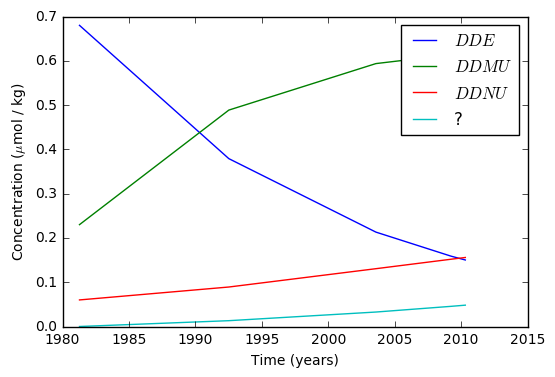

In [3]:
# See my other notebook where decay rates are global 
# so they can be seen inside the function 
k = np.array([.052, .01, .0161, .0])

# define a function to represent coupled ordinary differential eqns.
# this version allows for a fourth loss term that applies to all compounds
def dcdt(c, t, k):
    dfdt = np.zeros(4)
    dfdt[0] = c[0]* -k[0] - c[0]*k[3]
    dfdt[1] = c[1]* -k[1] + c[0]*k[0] - c[1]*k[3] 
    dfdt[2] = c[2]* -k[2] + c[1]*k[1] - c[2]*k[3]
    dfdt[3] =               c[2]*k[2] - c[3]*k[3]
    return dfdt
    
# intial concentration for four constituents
C0 = np.array([.68, .23, .06, 0.])

# time array
# t = linspace(0.0,100.,50)

# or, for discrete times that match measurements:
t = np.array(( 1981.27, 1992.51, 2003.58, 2009.23, 2010.31 ))

# Use the 
C = odeint(dcdt,C0,t, args = (k,))

fig = plt.figure()
plt.plot(t,C[:,0],label='$DDE$')
plt.plot(t,C[:,1],label='$DDMU$')
plt.plot(t,C[:,2],label='$DDNU$')
plt.plot(t,C[:,3],label='?')
plt.xlabel('Time (years)')
plt.ylabel('Concentration ($\mu$mol / kg)')
plt.legend(loc='upper right')

In [4]:
# version of 
# define a function to represent coupled ordinary differential eqns.
def dcdt3(c, t, k):
    dfdt = np.zeros(3)
    dfdt[0] = c[0]* -k[0]
    dfdt[1] = c[1]* -k[1] + c[0]*k[0]
    dfdt[2] = c[2]* -k[2] + c[1]*k[1]
    return dfdt

# objective function to minimize, fit through origin, estimate decay rate
def residual(params, t, data, eps_data):
    C0 = data[0]
    k = params['decay_rate']
    model = C0*np.exp(-k*(t-t[0]))
    return (data-model)/eps_data

# objective function to minimize, estimate origin and decay rate
def residual2(params, t, data, eps_data):
    C0 = params['init_conc']
    k = params['decay_rate']
    model = C0*np.exp(-k*(t-t[0]))
    return (data-model)/eps_data

def residual3(params, t, data, eps_data):
    # Data is passed as a vector
    # Index on length of time array to find intitial concentrations
    nt = t.size
    k = np.array((params['k1'],params['k2'],params['k3']))
    C0 = np.array((data[0],data[nt],data[2*nt]))
    C = odeint(dcdt3,C0,t, args = (k,))
    model = np.concatenate((C[:,0],C[:,1],C[:,2]))
    return (data-model)/eps_data
    

# Data for DDE loss only
data = DDE
eps_data = eps_DDE
# Adjust inventories according to PCB inventories?
if(1):
    data = data*adj
    eps_data = np.sqrt( (eps_data/data.mean())**2. + (eps_adj/adj.mean())**2. )

print('data: ', data)
print('eps_data: ',eps_data)
    
#r = residual(params, t, data, eps_data)
#m = data[0]*np.exp(-params['decay_rate']*(t-t[0]))
#print("model: ",m)
#print("residuals: ",r)

print('\n\nEstimate decay rate with fit through origin')
params = Parameters()
# Note that this does not work if there are extra parameters
#params.add('init_conc',value = 1., min = 0., max= 5.)
params.add('decay_rate',value = 0.4, min =0., max = 1.)
out = minimize(residual, params, method='leastsq', args=(t,data,eps_data))
report_fit(out)

print('\n\nEstimate decay rate and initial conc')
params = Parameters()
params.add('init_conc',value = 1., min = 0., max= 5.)
params.add('decay_rate',value = 0.4, min =0., max = 1.)
out = minimize(residual2, params, method='leastsq', args=(t,data,eps_data))
report_fit(out)

('data: ', array([ 1.48773292,  0.63392857,  0.26343168,  0.4484472 ,  0.46793478]))
('eps_data: ', array([ 0.21580036,  0.19789954,  0.19273254,  0.19261796,  0.1929704 ]))


Estimate decay rate with fit through origin
[[Fit Statistics]]
    # function evals   = 17
    # data points      = 5
    # variables        = 1
    chi-square         = 2.692
    reduced chi-square = 0.673
    Akaike info crit   = -1.095
    Bayesian info crit = -1.486
[[Variables]]
    decay_rate:   0.05675528 +/- 0.009083 (16.00%) (init= 0.4)
[[Correlations]] (unreported correlations are <  0.100)


Estimate decay rate and initial conc
[[Fit Statistics]]
    # function evals   = 32
    # data points      = 5
    # variables        = 2
    chi-square         = 2.591
    reduced chi-square = 0.864
    Akaike info crit   = 0.712
    Bayesian info crit = -0.069
[[Variables]]
    init_conc:    1.42009279 +/- 0.192105 (13.53%) (init= 1)
    decay_rate:   0.05413850 +/- 0.012228 (22.59%) (init= 0.4)
[[Correlations]] 

In [5]:
# Put data for all compounds in a single vector
data = np.concatenate((DDE,DDMU,DDNU))
eps_data = np.concatenate((eps_DDE,eps_DDMU,eps_DDNU))

# got terrible results using eps_data
eps_data = np.ones_like(data)
nt = t.size

print('\n\nFull monty')
params = Parameters()
params.add('k1',value = 0.4, min =0., max = 1.)
params.add('k2',value = 0.4, min =0., max = 1.)
params.add('k3',value = 0.4, min =0., max = 1.)

# Test the ODE solver
k = np.array((params['k1'],params['k2'],params['k3']))
C0 = np.array((data[0],data[nt],data[2*nt]))
C = odeint(dcdt3,C0,t, args = (k,))
model = np.concatenate((C[:,0],C[:,1],C[:,2]))
print("model shape:", shape(model))
print(model)
print("data shape:", shape(data))
print(data)

# Test the objective function outside
res = residual3(params, t, data, eps_data)
print("residual3 shape:",shape(res))

# Optimize the parameters using least-squares fit
out = minimize(residual3, params, method='leastsq', args=(t,data,eps_data))
report_fit(out)

k1out=out.params['k1'].value
k2out=out.params['k2'].value
k3out=out.params['k3'].value
print(k1out,k2out,k3out)
print(out.params)



Full monty
('model shape:', (15,))
[  1.34000000e+00   1.49457181e-02   1.78426348e-04   1.86190119e-05
   1.20876848e-05   7.00000000e-02   6.79767009e-02   1.60160119e-03
   2.09207194e-04   1.41041476e-04   4.00000000e-03   1.54611352e-01
   7.18848083e-03   1.17538075e-03   8.22871017e-04]
('data shape:', (15,))
[ 1.34   0.71   0.39   0.38   0.41   0.07   0.25   0.32   0.52   0.52
  0.004  0.012  0.036  0.069  0.085]
('residual3 shape:', (15,))
[[Fit Statistics]]
    # function evals   = 49
    # data points      = 15
    # variables        = 3
    chi-square         = 0.092
    reduced chi-square = 0.008
    Akaike info crit   = -70.450
    Bayesian info crit = -68.326
[[Variables]]
    k1:   0.04570187 +/- 0.004178 (9.14%) (init= 0.4)
    k2:   0.05628723 +/- 0.009067 (16.11%) (init= 0.4)
    k3:   0.46030277 +/- 0.389472 (84.61%) (init= 0.4)
[[Correlations]] (unreported correlations are <  0.100)
    C(k1, k2)                    =  0.323 
(0.045701873883497557, 0.0562872351138

Site3C.date = A(:,1);
Site3C.DDE = A(:,2);
Site3C.DDMU = A(:,3);
Site3C.DDNU = A(:,4);
Site3C.PCB118 = A(:,5);
Site3C.PCB153 = A(:,6);
Site3C.PCB138 = A(:,7);
Site3C.names = {{'sampling date (decimal year)'},...
  {'p,p''-DDE (mmol/cm2)'},...
  {'p,p''-DDMU (mmol/cm2)'},...
  {'p,p''-DDNU (mmol/cm2)'},...
  {'PCB 118 (mmol/cm2)'},...
  {'PCB 153 (mmol/cm2)'},...
  {'PCB 138 (mmol/cm2)'}}
Site3C.source = {'Data from spreadsheet e-mailed to CRS from Bob Eganhouse 16-Dec-2016 ''Inventories for C.Sherwood 12-16-2016.xlsx'''};